## Introduction + Set-up

This tutorial will explain how to build an X-ray image classification model
to predict whether an X-ray scan shows presence of pneumonia.

In [1]:
import re
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()
    print("Device:", tpu.master())
    strategy = tf.distribute.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

Device: 
Number of replicas: 8


We need a Google Cloud link to our data to load the data using a TPU.
Below, we define key configuration parameters we'll use in this example.
To run on TPU, this example must be on Colab with the TPU runtime selected.

In [2]:
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 25 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
CLASS_NAMES = ["NORMAL", "PNEUMONIA"]

## Load the data

The Chest X-ray data we are using from
[*Cell*](https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5) divides the data into
training and test files. Let's first load in the training TFRecords.

In [3]:
train_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/images.tfrec"
)
train_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/train/paths.tfrec"
)

ds = tf.data.Dataset.zip((train_images, train_paths))

Let's count how many healthy/normal chest X-rays we have and how many
pneumonia chest X-rays we have:

In [4]:
COUNT_NORMAL = len(
    [
        filename
        for filename in train_paths
        if "NORMAL" in filename.numpy().decode("utf-8")
    ]
)
print("Normal images count in training set: " + str(COUNT_NORMAL))

COUNT_PNEUMONIA = len(
    [
        filename
        for filename in train_paths
        if "PNEUMONIA" in filename.numpy().decode("utf-8")
    ]
)
print("Pneumonia images count in training set: " + str(COUNT_PNEUMONIA))

Normal images count in training set: 1349
Pneumonia images count in training set: 3883


Notice that there are way more images that are classified as pneumonia than normal. This
shows that we have an imbalance in our data. We will correct for this imbalance later on
in our notebook.

We want to map each filename to the corresponding (image, label) pair. The following
methods will help us do that.

As we only have two labels, we will encode the label so that `1` or `True` indicates
pneumonia and `0` or `False` indicates normal.

In [5]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, "/")
    # The second to last is the class-directory
    if parts[-2] == "PNEUMONIA":
        return 1
    else:
        return 0


def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.image.decode_jpeg(img, channels=3)
    # resize the image to the desired size.
    return tf.image.resize(img, IMAGE_SIZE)


def process_path(image, path):
    label = get_label(path)
    # load the raw data from the file as a string
    img = decode_img(image)
    return img, label


ds = ds.map(process_path, num_parallel_calls=AUTOTUNE)

Let's split the data into a training and validation datasets.

In [6]:
ds = ds.shuffle(10000)
train_ds = ds.take(4200)
val_ds = ds.skip(4200)

Let's visualize the shape of an (image, label) pair.

In [7]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  1


Load and format the test data as well.

In [8]:
test_images = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/images.tfrec"
)
test_paths = tf.data.TFRecordDataset(
    "gs://download.tensorflow.org/data/ChestXRay2017/test/paths.tfrec"
)
test_ds = tf.data.Dataset.zip((test_images, test_paths))

test_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)

## Visualize the dataset

First, let's use buffered prefetching so we can yield data from disk without having I/O
become blocking.

Please note that large image datasets should not be cached in memory. We do it here
because the dataset is not very large and we want to train on TPU.

In [9]:
def prepare_for_training(ds, cache=True):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

Call the next batch iteration of the training data.

In [10]:
train_ds = prepare_for_training(train_ds)
val_ds = prepare_for_training(val_ds)

image_batch, label_batch = next(iter(train_ds))

Define the method to show the images in the batch.

In [11]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10, 10))
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255)
        if label_batch[n]:
            plt.title("PNEUMONIA")
        else:
            plt.title("NORMAL")
        plt.axis("off")

As the method takes in NumPy arrays as its parameters, call the numpy function on the
batches to return the tensor in NumPy array form.

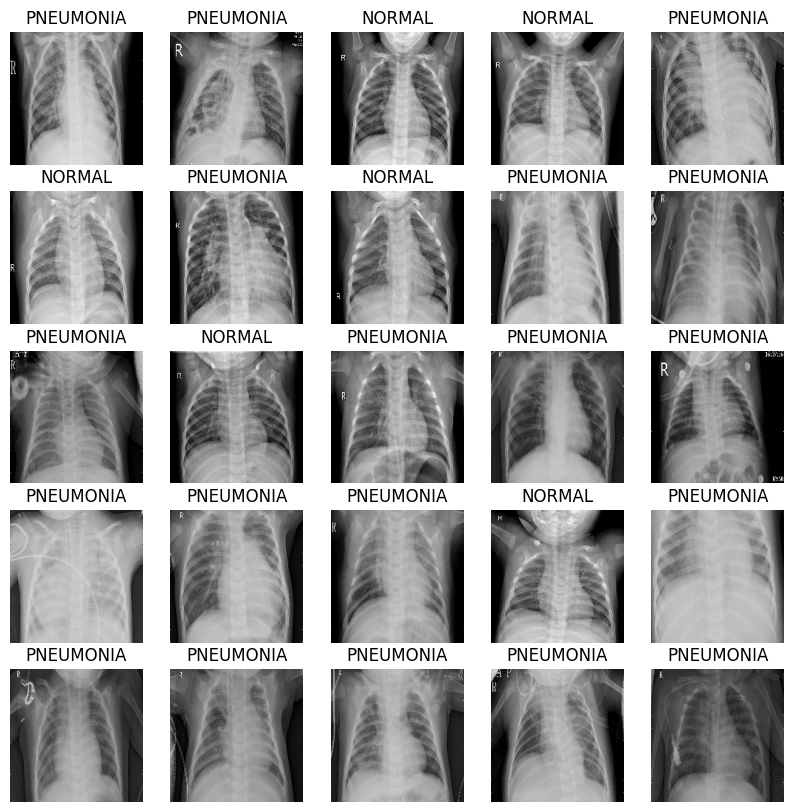

In [12]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Build the CNN

To make our model more modular and easier to understand, let's define some blocks. As
we're building a convolution neural network, we'll create a convolution block and a dense
layer block.

The architecture for this CNN has been inspired by this
[article](https://towardsdatascience.com/deep-learning-for-detecting-pneumonia-from-x-ray-images-fc9a3d9fdba8).

In [13]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras
from keras import layers


def conv_block(filters, inputs):
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(inputs)
    x = layers.SeparableConv2D(filters, 3, activation="relu", padding="same")(x)
    x = layers.BatchNormalization()(x)
    outputs = layers.MaxPool2D()(x)

    return outputs


def dense_block(units, dropout_rate, inputs):
    x = layers.Dense(units, activation="relu")(inputs)
    x = layers.BatchNormalization()(x)
    outputs = layers.Dropout(dropout_rate)(x)

    return outputs

The following method will define the function to build our model for us.

The images originally have values that range from [0, 255]. CNNs work better with smaller
numbers so we will scale this down for our input.

The Dropout layers are important, as they
reduce the likelikhood of the model overfitting. We want to end the model with a `Dense`
layer with one node, as this will be the binary output that determines if an X-ray shows
presence of pneumonia.

In [14]:
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, 3, activation="relu", padding="same")(x)
    x = layers.MaxPool2D()(x)

    x = conv_block(32, x)
    x = conv_block(64, x)

    x = conv_block(128, x)
    x = layers.Dropout(0.2)(x)

    x = conv_block(256, x)
    x = layers.Dropout(0.2)(x)

    x = layers.Flatten()(x)
    x = dense_block(512, 0.7, x)
    x = dense_block(128, 0.5, x)
    x = dense_block(64, 0.3, x)

    outputs = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Correct for data imbalance

We saw earlier in this example that the data was imbalanced, with more images classified
as pneumonia than normal. We will correct for that by using class weighting:

In [15]:
initial_bias = np.log([COUNT_PNEUMONIA / COUNT_NORMAL])
print("Initial bias: {:.5f}".format(initial_bias[0]))

TRAIN_IMG_COUNT = COUNT_NORMAL + COUNT_PNEUMONIA
weight_for_0 = (1 / COUNT_NORMAL) * (TRAIN_IMG_COUNT) / 2.0
weight_for_1 = (1 / COUNT_PNEUMONIA) * (TRAIN_IMG_COUNT) / 2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print("Weight for class 0: {:.2f}".format(weight_for_0))
print("Weight for class 1: {:.2f}".format(weight_for_1))

Initial bias: 1.05724
Weight for class 0: 1.94
Weight for class 1: 0.67


The weight for class `0` (Normal) is a lot higher than the weight for class `1`
(Pneumonia). Because there are less normal images, each normal image will be weighted
more to balance the data as the CNN works best when the training data is balanced.

## Train the model

### Defining callbacks

The checkpoint callback saves the best weights of the model, so next time we want to use
the model, we do not have to spend time training it. The early stopping callback stops
the training process when the model starts becoming stagnant, or even worse, when the
model starts overfitting.

In [16]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("xray_model.keras", save_best_only=True)

early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=10, restore_best_weights=True
)

We also want to tune our learning rate. Too high of a learning rate will cause the model
to diverge. Too small of a learning rate will cause the model to be too slow. We
implement the exponential learning rate scheduling method below.

In [17]:
initial_learning_rate = 0.015
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)

### Fit the model

For our metrics, we want to include precision and recall as they will provide use with a
more informed picture of how good our model is. Accuracy tells us what fraction of the
labels is correct. Since our data is not balanced, accuracy might give a skewed sense of
a good model (i.e. a model that always predicts PNEUMONIA will be 74% accurate but is not
a good model).

Precision is the number of true positives (TP) over the sum of TP and false positives
(FP). It shows what fraction of labeled positives are actually correct.

Recall is the number of TP over the sum of TP and false negatves (FN). It shows what
fraction of actual positives are correct.

Since there are only two possible labels for the image, we will be using the
binary crossentropy loss. When we fit the model, remember to specify the class weights,
which we defined earlier. Because we are using a TPU, training will be quick - less than
2 minutes.

In [18]:
with strategy.scope():
    model = build_model()

    METRICS = [
        keras.metrics.BinaryAccuracy(),
        keras.metrics.Precision(name="precision"),
        keras.metrics.Recall(name="recall"),
    ]
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        loss="binary_crossentropy",
        metrics=METRICS,
    )

history = model.fit(
    train_ds,
    epochs=100,
    validation_data=val_ds,
    class_weight=class_weight,
    callbacks=[checkpoint_cb, early_stopping_cb],
)

Epoch 1/100
     21/Unknown 31s 122ms/step - binary_accuracy: 0.5535 - loss: 0.7811 - precision: 0.8154 - recall: 0.5313

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


21/21 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - binary_accuracy: 0.5583 - loss: 0.7752 - precision: 0.8179 - recall: 0.5361 - val_binary_accuracy: 0.7067 - val_loss: 0.6258 - val_precision: 0.7626 - val_recall: 0.9060
Epoch 2/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 263ms/step - binary_accuracy: 0.8144 - loss: 0.3535 - precision: 0.9554 - recall: 0.7925 - val_binary_accuracy: 0.3267 - val_loss: 1.6264 - val_precision: 0.9444 - val_recall: 0.1453
Epoch 3/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 282ms/step - binary_accuracy: 0.9223 - loss: 0.2098 - precision: 0.9854 - recall: 0.9102 - val_binary_accuracy: 0.8333 - val_loss: 0.3881 - val_precision: 0.9182 - val_recall: 0.8632
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 258ms/step - binary_accuracy: 0.9252 - loss: 0.1689 - precision: 0.9841 - recall: 0.9157 - val_binary_accuracy: 0.7800 - val_loss: 1.3033 - val_precision: 0.7800 - val_recall: 1.0000
Epoch 5/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 7s 291ms/step - binary_accuracy: 0.9326 - loss: 0.1247 - precision: 0.9854 

## Visualizing model performance

Let's plot the model accuracy and loss for the training and the validating set. Note that
no random seed is specified for this notebook. For your notebook, there might be slight
variance.

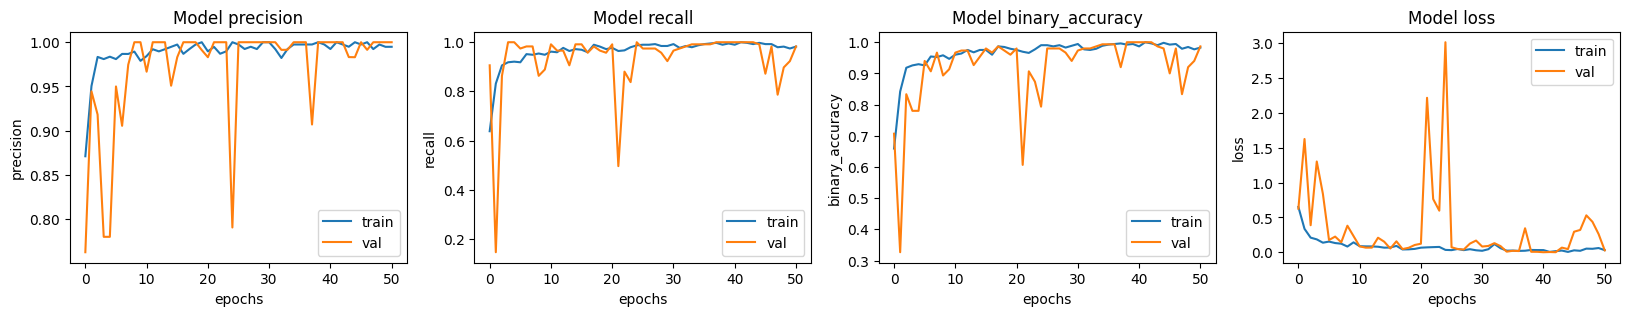

In [19]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(["precision", "recall", "binary_accuracy", "loss"]):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history["val_" + met])
    ax[i].set_title("Model {}".format(met))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(met)
    ax[i].legend(["train", "val"])

We see that the accuracy for our model is around 95%.

## Predict and evaluate results

Let's evaluate the model on our test data!

In [20]:
model.evaluate(test_ds, return_dict=True)

4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 2s/step - binary_accuracy: 0.5159 - loss: 5.0108 - precision: 0.3192 - recall: 0.5757


{'binary_accuracy': 0.6464646458625793,
 'loss': 4.20615291595459,
 'precision': 0.5874999761581421,
 'recall': 0.9591836929321289}

We see that our accuracy on our test data is lower than the accuracy for our validating
set. This may indicate overfitting.

Our recall is greater than our precision, indicating that almost all pneumonia images are
correctly identified but some normal images are falsely identified. We should aim to
increase our precision.

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
This image is 43.65 percent NORMAL
This image is 56.35 percent PNEUMONIA


<ipython-input-21-d4c28b2be0ce>:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("This image is %.2f percent %s" % ((100 * score), name))


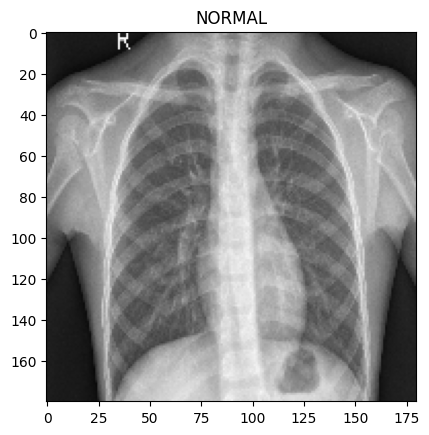

In [21]:
for image, label in test_ds.take(1):
    plt.imshow(image[0] / 255.0)
    plt.title(CLASS_NAMES[label[0].numpy()])

prediction = model.predict(test_ds.take(1))[0]
scores = [1 - prediction, prediction]

for score, name in zip(scores, CLASS_NAMES):
    print("This image is %.2f percent %s" % ((100 * score), name))